<a href="https://colab.research.google.com/github/feelzoo/Ecommerce_FreeShipping_Threshold_Shipping_Rates/blob/main/Copy_of_Shipping_cost_and_minimum_order_value_for_free_shipping_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Free Shipping Threshold & Shipping Rates for Ecommerce**

In this project, I will perform data anlaysis that can help to make two business/logistical decisions for our ecommerce website as below: 


*   Determinig Free Shipping Threshold
*   Updating Shipping Rates

#### My Functions

In [181]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from operator import itemgetter
from palettable.colorbrewer.diverging import *
from matplotlib import cm

In [182]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/NADRI/Shopify_Order_Product_Returns'
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [183]:
#@title
#for 'Shopify order data', split datetime into 'year' and 'month'
def year_month(data):
    data['year'] = ''
    data['month'] = ''
    for index, row in data.iterrows():
        try: 
            year = str(row['Created at']).split('-')[0]
            month = str(row['Created at']).split('-')[1]
        except: 
            year = '0'
            month = '0'
        data.at[index,'year'] = year
        data.at[index,'month'] = month

In [184]:
#@title
#for 'Shopify Order Data, create a histogram of average order value distribution
def AOV_distribution(df,tick,dis_type):
  fig = plt.figure(figsize = (15,10))
  sns.set_style('white')
  year_month(df)
  df_main = df[~df['Financial Status'].isna()]
  df_main_min = df_main[df_main.year == df_main.year.min()]
  df_main_max = df_main[df_main.year == df_main.year.max()]
  ax = sns.histplot(df_main['Total'],alpha = 1,label='2021',color = '#287094', binrange = (0,1000),bins=40,stat = dis_type)
  plt.legend(prop={'size':20})
  plt.title(f"Order Value Distribution {df_main_min['year'].min()}/{df_main_min['month'].min()}~{df_main_max['year'].min()}/{df_main_max['month'].max()}",fontsize = 30,fontweight='bold')
  plt.xlabel('Average Order Value per order',fontsize = 20)
  plt.ylabel('Number of Orders',fontsize = 20)
  plt.xticks(np.arange(0,1000,tick),fontsize = 13)
  plt.xlim(0,1000)
  plt.yticks(fontsize = 13)
  for p in ax.patches: 
    if dis_type == 'percent':
      value = f'{p.get_height():.0f}%'
    else:
      value = f'{p.get_height():.0f}'
    x= p.get_x() + p.get_width()/2
    y= p.get_height()
    ax.text(x,y,value,ha='center',va='bottom')
  return fig

In [185]:
#@title
#creating a column that put 'Shopify order value' into buckets 
def cat(x):
  bounds = list(range(50,200,25))+list(range(200,400,50))+list(range(400,1100,100))
  if x < bounds[0]:
    return f'<${bounds[0]}'
  if x>=bounds[-1]:
    return f'{bounds[-1]}over'

  for i in range(len(bounds) - 1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'

In [186]:
#@title
#creating a column that put 'Shopify order value' into buckets 
def cat2(x):
  bounds = list(range(50,225,25))
  if x < bounds[0]:
    return f'<${bounds[0]}'
  if x>=bounds[-1]:
    return f'{bounds[-1]}over'
  for i in range(len(bounds)-1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'

In [187]:
#@title
#creating a column that put 'Shopify order value' into buckets 
def cat3(x):
  bounds = list(range(10,25,15)) +list(range(25,125,25))
  if x <bounds[0]:
    return f'<${bounds[0]}'
  if x >= bounds[-1]:
    return f'{bounds[-1]}over'
  for i in range(len(bounds)-1):
    if bounds[i] <= x < bounds[i+1]:
      return f'\\${bounds[i]}~${bounds[i+1]}'


# 1.**Minimum Order Value for Free Shipping**
Current plan: Free standard shipping for orders over $50

We can start by finding the amount of money spent per order by customers to see how average order values are distributed. This will help us understand our consumer behaviors around the free shipping threshold.  

## a. Dataset

In [188]:
#Shopify order data downloded into two csv files due to size.  
order1 = f'{root_path}/orders_export_2.csv'
order2 = f'{root_path}/orders_export_1 2.csv'

#Combining two csv files into one 
orders = pd.concat(map(pd.read_csv,[order1,order2]),ignore_index = True)
year_month(orders)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:304: DtypeWarning: Columns (45,71) have mixed types.Specify dtype option on import or set low_memory=False.
  sort=sort,


In [189]:
new = '\n'
print(f'\033[1mRaw Data Shape\033[0m{new}# of rows:{orders.shape[0]}{new}# of columns:{orders.shape[1]}')
print(f'\033[1mList of columns\033[0m{new}{orders.columns}')

Raw Data Shape
# of rows:24058
# of columns:79
List of columns
Index(['Name', 'Email', 'Financial Status', 'Paid at', 'Fulfillment Status',
       'Fulfilled at', 'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping',
       'Taxes', 'Total', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem quantity', 'Lineitem name', 'Lineitem price',
       'Lineitem compare at price', 'Lineitem sku',
       'Lineitem requires shipping', 'Lineitem taxable',
       'Lineitem fulfillment status', 'Billing Name', 'Billing Street',
       'Billing Address1', 'Billing Address2', 'Billing Company',
       'Billing City', 'Billing Zip', 'Billing Province', 'Billing Country',
       'Billing Phone', 'Shipping Name', 'Shipping Street',
       'Shipping Address1', 'Shipping Address2', 'Shipping Company',
       'Shipping City', 'Shipping Zip', 'Shipping Province',
       'Shipping Country', 'Shipping Phone', 'Notes', 'Note Attributes',
       'Cancelled at', 'Payment Meth

## b. Order Value Data Preprocessing

In [190]:
#deselecting unnecessary rows
orders_new = orders[~orders['Financial Status'].isna()]
#creating price_range columns
orders_new['price range'] = orders_new['Total'].apply(cat)
orders_new['price range2'] = orders_new['Total'].apply(cat2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [191]:
#Preprocessing for order value distribution graph: labels, colors
dollar = list(range(50,200,25))+list(range(200,400,50))+list(range(400,1100,100))
dollar2 = list(range(50,225,25))
dollar3 = list(range(10,25,15))+list(range(25,125,25))
labels1 = []
for i in range(len(dollar)):
  if i == 0:
    labels1.append(f'<${dollar[0]}')
  if 1 <= i < len(dollar):
    labels1.append(f'\\${dollar[i-1]}~${dollar[i]}')
  if i == len(dollar)-1:
    labels1.append(f'\\${dollar[-1]} over')
labels2 = []
for i in range(len(dollar2)):
  if i == 0:
    labels2.append(f'<${dollar2[i]}')
  if 1 <= i < len(dollar2):
    labels2.append(f"\\${dollar2[i-1]}~${dollar2[i]}")
  if i == len(dollar2)-1:
    labels2.append(f"\\${dollar2[i]}over")
labels3 = []
for i in range(len(dollar3)):
  if i == 0:
    labels3.append(f'<${dollar3[i]}')
  if 1 <= i < len(dollar3):
    labels3.append(f"\\${dollar3[i-1]}~${dollar3[i]}")
  if i == len(dollar3)-1:
    labels3.append(f"\\${dollar3[i]}over")

## (Bar Graph = Pie Chart) for Number of Orders by Order Value

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


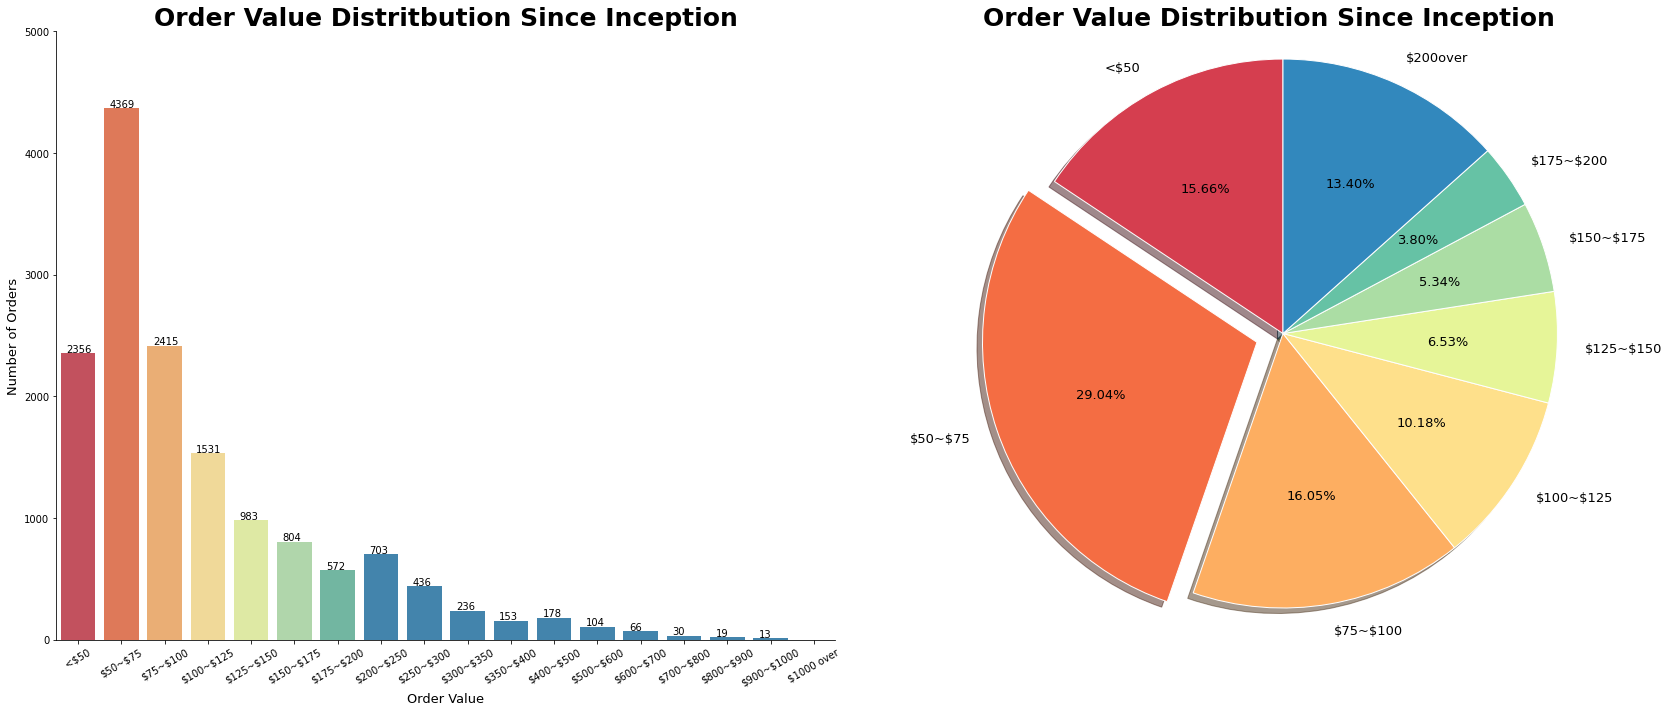

In [196]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
colors = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd']
ax = sns.countplot(orders_new['price range'],order=labels1,palette = colors)
plt.title('Order Value Distritbution Since Inception',fontsize=25,fontweight='bold')
plt.ylim([0,5000])
ax.set_xticklabels(labels1,rotation=30)
sns.despine(right=True,top = True)
plt.xlabel('Order Value',fontsize = 13)
plt.ylabel('Number of Orders',fontsize = 13)
for p in ax.patches: 
  number = f'{p.get_height():.0f}'
  x = p.get_x()+p.get_width()/6
  y = p.get_height() + 10
  plt.text(x,y,number)


plt.subplot(1,2,2)
count3 = [2356,4369,2415,1531,983,804,572,2016]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
explode = [0,.1,0,0,0,0,0,0]
patches, texts, autotexts = plt.pie(count3,labels = labels2,wedgeprops = {'linewidth':1,'edgecolor':'white'}, textprops = {'size': 13}, shadow=True,autopct = '%.2f%%',colors = color_pie,explode=explode,startangle=90)
plt.setp(autotexts,color = 'black',size='13')
plt.title('Order Value Distribution Since Inception',fontsize=25,fontweight='bold')
plt.axis('equal')
plt.tight_layout()


## **Insights**

### 29.04% of the orders fall into the \$50~\$75 bucket.

There are two hypotheses on the dominance of the \$50~\$75 bucket
1. Current Free Shipping Threshold is \$50 - Consumers get peace of mind with free shipping and \$50~\$75 is the cheapest bucket to do so. 

2. Half of our items are priced less than \$75. As can be seen in the below item price distribution graphs, 53.78% of our items are priced less than \$75. 


### Item distribution Data preprocessing

In [197]:
product = pd.read_csv(f'{root_path}/products.csv')
product2 = product.dropna(subset = ['Title'])
product2['price range'] = product2['Variant Price'].apply(cat)
product2['price range2'] = product2['Variant Price'].apply(cat2)
product2['price range3'] = product2['Variant Price'].apply(cat3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### (Bar Graph = Pie Chart) for Item Price Distribution

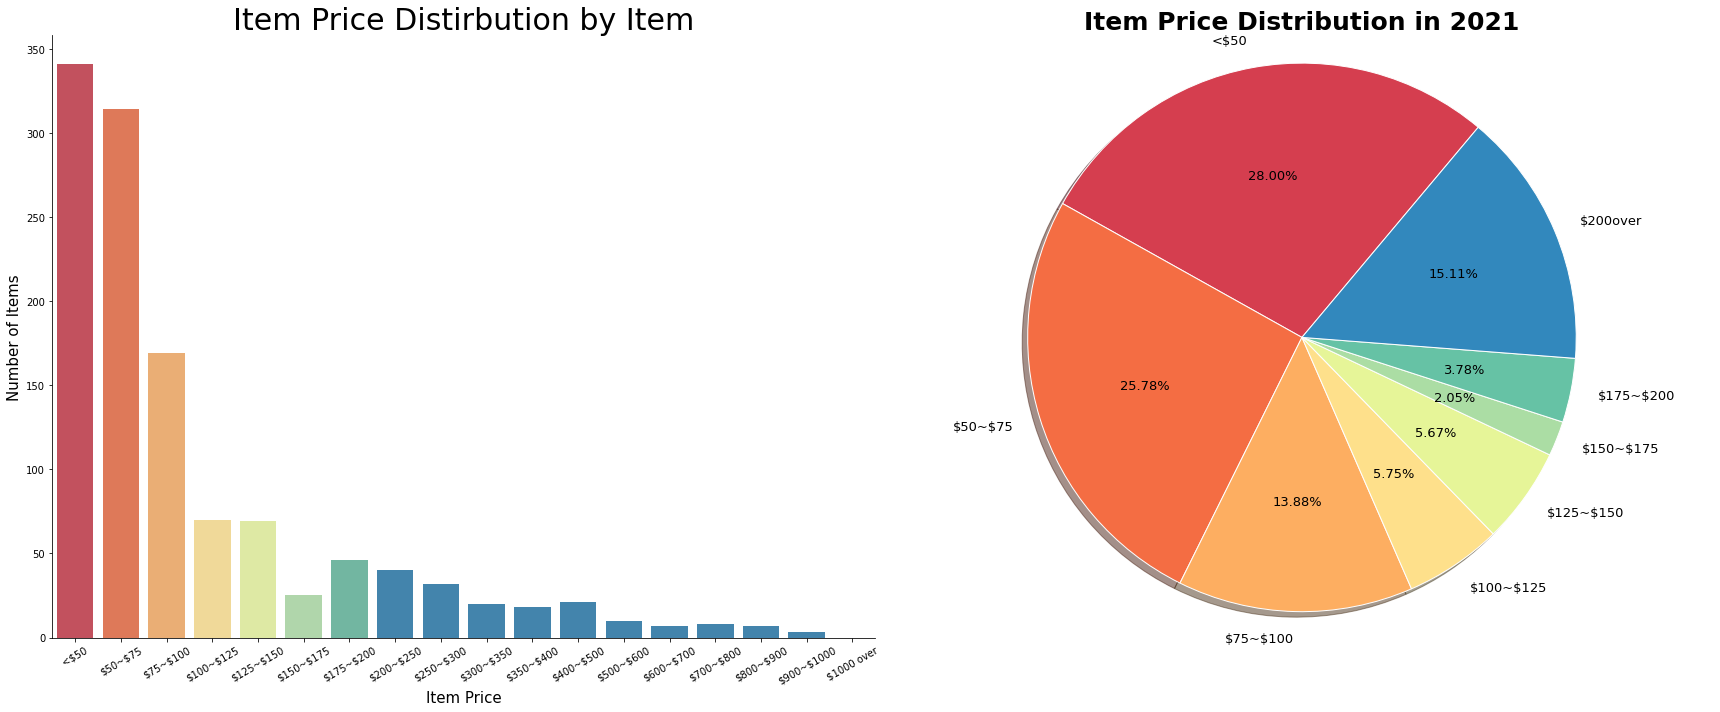

In [198]:
plt.figure(figsize = (24,10))
plt.subplot(1,2,1)
ax = sns.countplot(data = product2, x= 'price range',order = labels1,palette = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd','#3288bd'])
ax.set_xticklabels(labels1,rotation=30,color='black')
plt.title('Item Price Distirbution by Item',fontsize = 30)
plt.tight_layout()
plt.xlabel('Item Price',fontsize=15)
plt.ylabel('Number of Items',fontsize=15)
sns.despine(top = True, right = True)


plt.subplot(1,2,2)
count_item = [341,314,169,70,69,25,46,184]
color_pie = ['#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd']
colors.reverse()
patches, texts, autotexts = plt.pie(count_item,labels = labels2,wedgeprops={'linewidth': 1, 'edgecolor': 'white'},shadow=True,autopct = '%.2f%%',colors = color_pie,startangle=50,textprops={'size': 13})
plt.setp(autotexts,color = 'black',size='13')
plt.title('Item Price Distribution in 2021',fontsize=25,fontweight='bold')
plt.axis('equal')
plt.tight_layout()


#**Recommendations** 

Increasing our free shipping threshold from \$50 to \$75 is highly recommended. Consumers love free shipping and there are many items offered between \$0 and \$75 which will give consumers plenty of options to reach an order value of \$75. I expect that some of the \$50~\$75 bucket customers will definitely spill over to the next two buckets (\$75-\$100 and \$100-\$125) which will lead to a higher average order value (AOV) due to a higher threshold. There might be more cart abandonments during the spill over process. However, given that most of our competitors are embracing $75 threshold and consumers are more immune to higher fees due to the pandemic, the benefits will outweigh the disadvantage such as cart abandonment. 

#2. **New Shipping Rates**

In order to discover the best shipping rates for ecommerce, competitive, cost-based and order data analysis are conducted.  


1. ## **Competitive Analysis**

Brand    | Fresshipping Policy          |Ground|2nd Day|Next day| Note
-------------------|--------------------|-----|-------|-------|------|     
Brand A      | free USPS shipping over \$75 |\$7.00| \$12 | N/A |expedited is 3-5 days; no 2nd day or overnight option
Brand B      | free UPS shipping over \$75 |\$7/\$12 | \$20 |\$30 | \$7 ups surepost (5-8 days) \$12 UPS ground (3-5 days)
Brand C|free standard shipping over \$75|\$6.50| |\$15 | 
Brand D	|no free shipping at this moment|\$3.50 |\$17.95 |\$24.92 | Last year offered $10 next day shipping beginning 12/19
Brand E	|free shipping & returns|Free|\$20.00 | \$30.00
Brand F	|free expedited shipping on all orders|Free|Free|\$15 | free standard shipping is 2-4 days


2. ## **Cost-Based Analysis** <br>
Our shipping costs won't be heavily affected by the carrier's rate changes due to utilizing FedEx One Rate and Shopify discount plans.  


Shipping Method    | Condition          |Rate|Cost update
-------------------|--------------------|-----|-------     
USPS - Flat Rate Shipping      | \$0.00–\$49.99 |\$5.00| cost increased by \$0.3
Free USPS free Shipping      | \$50.00–\$149.99 |Free | cost increased by \$0.3
Free UPS Ground shipping|\$150.00–\$499.00|Free| Shopify won't increase
2nd Day Air - FedEx	|\$0.00–\$499.99|\$14.95 |
Next Day Air - UPS	|\$0.00–\$999.99|\$29.95|Shopify won't increase
Free 2nd Day Air - FedEx	|\$500.00–\$999.99|Free|
Free Next Day Air - UPS	|\$1,000.00 and up|Free|Shopify won't increase








3. ## **Order Data Analysis** <br>

a. **Standard Shipping** The cost of the standard shipping will increase by 7% ~ 9%. 

b. **Air Shipping** As can be seen in the charts below indicating the number of orders by a shipping method over the last 4 years, there are no significant difference in the number of 2nd day and next day air shipments. This might indicate that customer’s decision on selecting 2nd day or next day air is largely driven by the urgency of the order rather than the price. Therefore, increasing the express shipment rates wouldn't hurt the conversion rate significantly.    


### preprocessing

In [199]:
combined4 = orders.groupby(['Name','Shipping Method','year'])['Lineitem quantity','Lineitem price','Shipping'].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [200]:
y_2017 = combined4[combined4['year'] == '2017']
y_2018 = combined4[combined4['year'] == '2018']
y_2019 = combined4[combined4['year'] == '2019']
y_2020 = combined4[combined4['year'] == '2020']
y_2021 = combined4[combined4['year'] == '2021']

In [201]:
y_2017 = y_2017[y_2017['Shipping Method'] != 'In store shipping']
y_2018 = y_2018[y_2018['Shipping Method'] != 'In store shipping']

#2017 Shipping Method
next_2017 = y_2017[y_2017['Shipping Method'].isin(['Next Day Air - UPS'])]
second_2017 = y_2017[y_2017['Shipping Method'].isin(['2nd Day Air - UPS','Free USPS Priority Mail'])]
ground_2017 = y_2017[y_2017['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground - UPS'])]
other_2017 = y_2017[y_2017['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom'])]

#2018 Shipping Method
next_2018 = y_2018[y_2018['Shipping Method'].isin(['Next Day Air - UPS'])]
second_2018 = y_2018[y_2018['Shipping Method'].isin(['2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS'])]
ground_2018 = y_2018[y_2018['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','Ground - UPS'])]
other_2018 = y_2018[y_2018['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee'])]

#2019 Shpping Method
next_2019 = y_2019[y_2019['Shipping Method'].isin(['Next Day Air - UPS','Free Overnight UPS','Free Next Day UPS','USPS PRIORITY EXPRESS SERVICE'])]
second_2019 = y_2019[y_2019['Shipping Method'].isin(['2nd Day UPS','2nd Day - UPS','2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day UPS - Holiday Promotion'])]
ground_2019 = y_2019[y_2019['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','USPS Free Shipping','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','UPS Ground Shipping','Free Ground Shipping','UPS GROUND SHIPPING','Free Ground Shipping','UPS Ground Shipping Fee','UPS Ground Shipping','Free shipping'])]
other_2019 = y_2019[y_2019['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee','DHL WORLDWIDE EXPRESS SHIPMENT','DHL WORLDWIDE EXPRESS SHIPPING FEE','DHL - EXPRESS WORLDWIDE SHIPPING FEE','DHL Worldwide Express','Worldwide Express - DHL','Worldwide Express - DHL','DHL WorldWide Express Shipping Fee'])]


#2020 Shipping Method
next_2020 = y_2020[y_2020['Shipping Method'].isin(['Next Day Air - UPS','Free Overnight UPS','USPS PRIORITY EXPRESS SERVICE','Next Day Air','Free Next Day Air - UPS'])]
second_2020 = y_2020[y_2020['Shipping Method'].isin(['2nd Day UPS','2nd Day - UPS','2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day UPS - Holiday Promotion','Free 2nd Day Air - UPS','2nd Day Air - UPS','Free 2nd day - UPS','2nd Day UPS','Free 2nd Day UPS'])]
ground_2020 = y_2020[y_2020['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','USPS Free Shipping','Flat Rate Shipping  - USPS','USPS - Flat Rate Shipping','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','UPS Ground Shipping','Free Ground Shipping','Free shipping','UPS Ground Shipping Fee'])]
other_2020 = y_2020[y_2020['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee','DHL WORLDWIDE EXPRESS SHIPMENT','DHL WORLDWIDE EXPRESS SHIPPING FE','DHL - EXPRESS WORLDWIDE SHIPPING FEE','DHL Worldwide Express','Worldwide'])]

#2021 Shipping Method
next_2021 = y_2021[y_2021['Shipping Method'].isin(['Next Day Air - UPS','Free Overnight UPS','USPS PRIORITY EXPRESS SERVICE','Next Day Air','Free Next Day Air - UPS'])]
second_2021 = y_2021[y_2021['Shipping Method'].isin(['2nd Day UPS','2nd Day - UPS','2nd Day Air - UPS','Free USPS Priority Mail','2nd Day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day UPS - Holiday Promotion','Free 2nd Day Air - UPS','2nd Day Air - UPS','Free 2nd day - UPS','2nd Day UPS','Free 2nd Day UPS','2nd Day Air - FedEx','Free 2nd Day Air - FedEx','Free 2nd Day Air - UPS'])]
ground_2021 = y_2021[y_2021['Shipping Method'].isin(['Free Ground Shipping - UPS','Ground Shipping - UPS','USPS Free Shipping','Flat Rate Shipping  - USPS','USPS - Flat Rate Shipping','UPS GROUND SHIPPING','UPS GROUND SHIPPING FEE','UPS Ground','UPS Ground Delivery Service','UPS Ground Shipping','UPS Ground Shipping Fee','UPS STANDARD SHIPPING FEE','UPS Standard Ground','UPS Ground Service','UPS GROUND SERVICE','Standard UPS Ground Shipping','STANDARD UPS GROUND SERVICE','STANDARD UPS GROUND SERVICE','SHIPPING UPS GROUND','UPS SHIPPING FEE','UPS Shipping Fee','UPS Ground Shipping','Free Ground Shipping','Free shipping','UPS Ground Shipping Fee','Flat Rate Shipping  - USPS','Free UPS Ground shipping','Free Ground Shipping -UPS'])]
other_2021 = y_2021[y_2021['Shipping Method'].isin(['In store shipping','Express Worldwide - DHL','Custom','DHL Express Worldwide Shipping Fee','DHL WORLDWIDE EXPRESS SHIPMENT','DHL WORLDWIDE EXPRESS SHIPPING FE','DHL - EXPRESS WORLDWIDE SHIPPING FEE','DHL Worldwide Express','Worldwide','Express Worldwide - DHL (0.7 lb)'])]


In [202]:
shipping_price = orders[['year','Shipping Method','Shipping']]

In [203]:
method = ['Ground','2nd Day Air','Next Day Air','Other']

In [204]:
shipping_2017 = pd.DataFrame(data = [[len(ground_2017),len(second_2017),len(next_2017),len(other_2017)]],columns=method)
shipping_2018 = pd.DataFrame(data = [[len(ground_2018),len(second_2018),len(next_2018),len(other_2018)]],columns=method)
shipping_2019 = pd.DataFrame(data = [[len(ground_2019),len(second_2019),len(next_2019),len(other_2019)]],columns=method)
shipping_2020 = pd.DataFrame(data = [[len(ground_2020),len(second_2020),len(next_2020),len(other_2020)]],columns=method)
shipping_2021 = pd.DataFrame(data = [[len(ground_2021),len(second_2021),len(next_2021),len(other_2021)]],columns=method)

In [205]:
shipping_2017 = list([len(ground_2017),len(second_2017),len(next_2017),len(other_2017)])
shipping_2018 = list([len(ground_2018),len(second_2018),len(next_2018),len(other_2018)])
shipping_2019 = list([len(ground_2019),len(second_2019),len(next_2019),len(other_2019)])
shipping_2020 = list([len(ground_2020),len(second_2020),len(next_2020),len(other_2020)])
shipping_2021 = list([len(ground_2021),len(second_2021),len(next_2021),len(other_2021)])

In [206]:
shipping_stats = [shipping_2017,shipping_2018,shipping_2019,shipping_2020,shipping_2021]

### Shipping Method Pie Chart by year

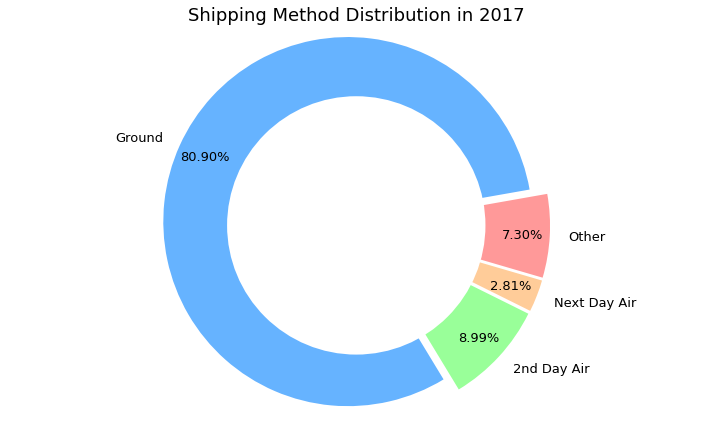

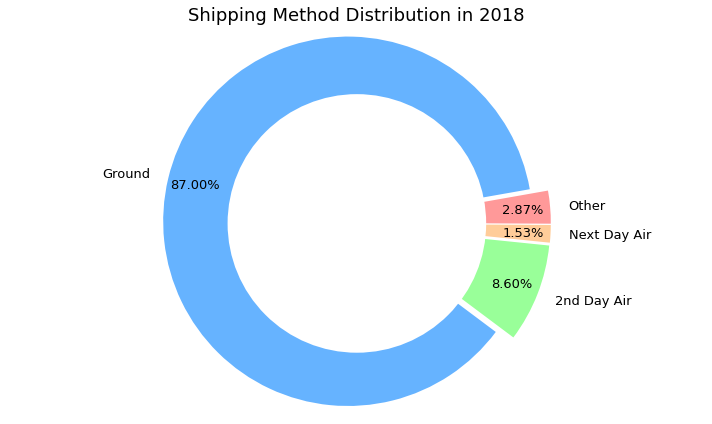

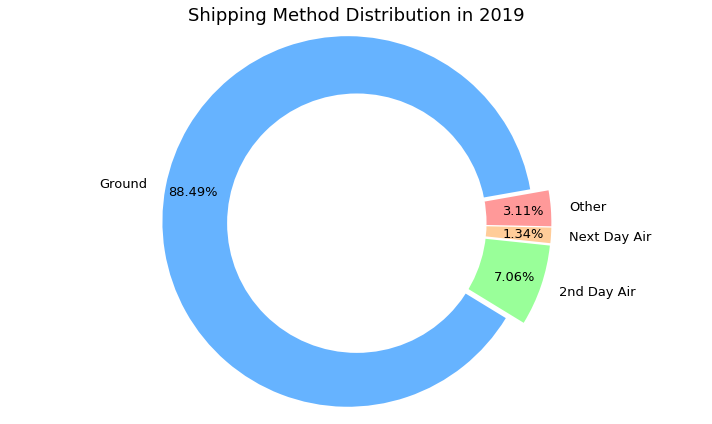

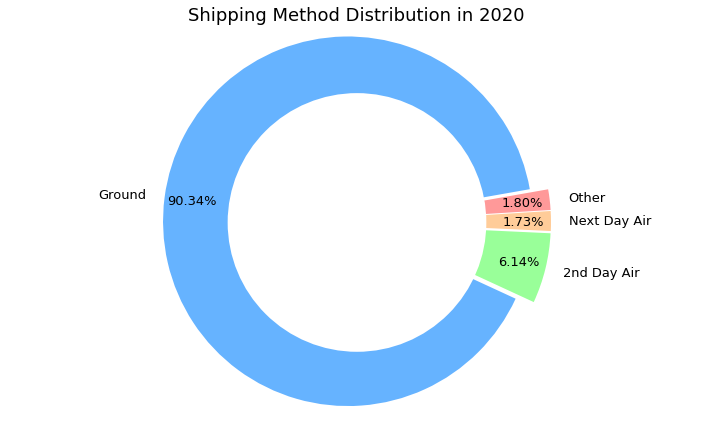

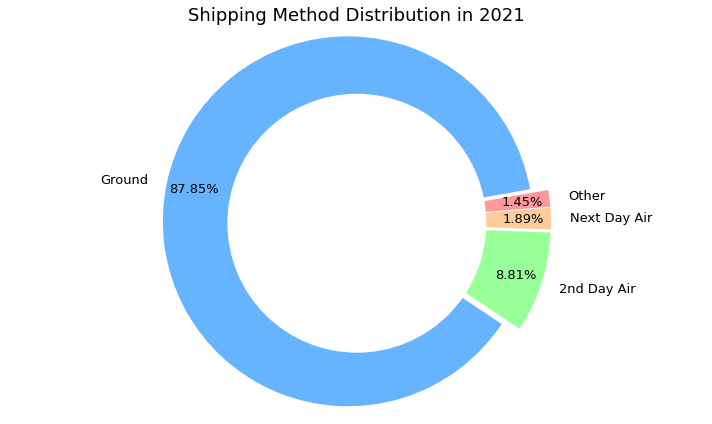

In [207]:
for i in range(len(shipping_stats)):
    plt.figure(figsize=(10,6))
    colors2 = ['#66b3ff','#99ff99','#ffcc99','#ff9999']
    explode = (.05,.05,.05,.05)
    plt.pie(shipping_stats[i],labels = method,colors=colors2, autopct = '%.2f%%',textprops = {'fontsize': 13},explode=explode,startangle=10,pctdistance=.85)
    plt.title('Shipping Method Distribution in {0}'.format(2017+i),fontsize=18)
    center_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('Shipping Method in {0}.png'.format(2017+i))
    plt.show()
    

#**Recommendations** 

I would recommend to raise the standard shipping price from \$5 to \$5.95 for order under \$75. I wouldn’t raise the prices for the 2nd day and next day air because our costs either decreased or stay the same and our current prices are similar to our competitors. Also, unlike the free shipping threshold, \$14.95 and \$24.95 are numerically high numbers so it might affect cart abandonments more significantly that increasing the free shipping threshold. However, as mentioned earlier in the shipping method analysis, choosing air shipments seems to be more influenced by their urgency than their price. Therefore, changing the airshipment prices wouldn't be able to make a sigificant impact on consumer behaviors. I would recommend to offer a free 2nd day air upgrade for orders over \$150 instead free UPS ground due to FedEx One Rate. In addition, adding small accessories or non-jewelry items (\$10 ~ \$30) will give consumers more options to play with these upgrades. 
